# Generating OBC and IC for NWA from global MOM6 model output
*James Simkins, based on an [example by Raphael Dussin](https://github.com/ESMG/regionalMOM6_notebooks/blob/master/creating_obc_input_files/CCS1_OBC_from_global_MOM6.ipynb)*

First let's describe the packages we're using:

- xarray: if you're not familiar, better catch up http://xarray.pydata.org/en/stable/
- xesmf: xarray-friendly horizontal remapping based on ESMF library. We will use it to remap data onto boundaries and regional domain. https://xesmf.readthedocs.io/en/latest/
- HCtFlood: horizontal 2D extrapolation package, used to replace NaN on land by closest ocean value. https://github.com/raphaeldussin/HCtFlood
- bottleneck: optimized compute kernels, needed for xr.ffill or xr.bfill. Make sure to have it installed (available through conda/pip)
- GFDL_xr: only a wrapper to xarray open functions with embedded retrieve from tape, can be replaced by xr if not at GFDL. https://github.com/raphaeldussin/GFDL_xr

In [1]:
#gridtools conda library - https://github.com/ESMG/gridtools/blob/main/conda/gridTools.yml
# additional pycnal regridding installed - https://github.com/ESMG/PyCNAL_regridding - with following command after cloning repo -  python -m pip install .
import xarray as xr
import xesmf
import bottleneck
import numpy as np

## 1. Loading SODA model output from the global model

In [2]:
ds = xr.open_dataset("soda3.3.1_5dy_ocean_reg_1993_01_04.nc")

## 2. Load the regional grid

In [3]:
ds_nwa = xr.open_dataset('~/Downloads/nwa_ocean_hgrid.nc')

## 3. Subsetting the domain

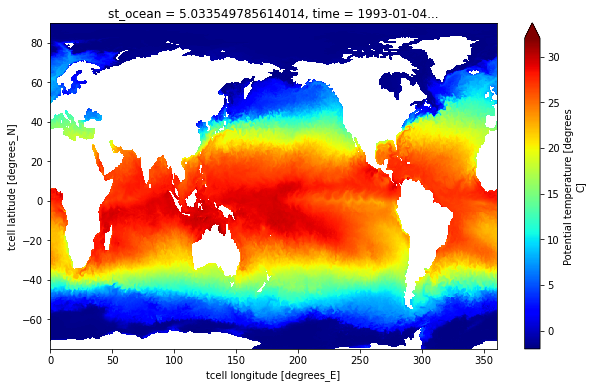

In [4]:
ds['temp'].isel(time=0, st_ocean=0).plot(figsize=[10,6], vmin=-2, vmax=32, cmap='jet')

In [5]:
ds_cut = ds.sel(xt_ocean=slice(np.min(ds_nwa.x.values), np.max(ds_nwa.x.values)), yt_ocean=slice(np.min(ds_nwa.y.values), np.max(ds_nwa.y.values)),
                xu_ocean=slice(np.min(ds_nwa.x.values), np.max(ds_nwa.x.values)), yu_ocean=slice(np.min(ds_nwa.y.values), np.max(ds_nwa.y.values)))

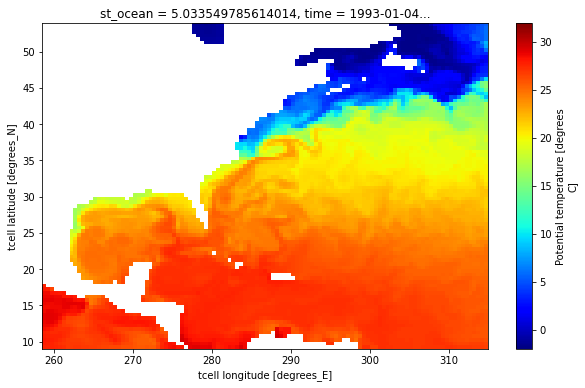

In [6]:
ds_cut['temp'].isel(time=0, st_ocean=0).plot(figsize=[10,6], vmin=-2, vmax=32, cmap='jet')

## 4. Regridding to Open Boundaries

In [7]:
# northern boundary
north = xr.Dataset()
north['lon'] = ds_nwa['x'].isel(nyp=-1)
north['lat'] = ds_nwa['y'].isel(nyp=-1)

# southern boundary
south = xr.Dataset()
south['lon'] = ds_nwa['x'].isel(nyp=0)
south['lat'] = ds_nwa['y'].isel(nyp=0)

# western boundary
west = xr.Dataset()
west['lon'] = ds_nwa['x'].isel(nxp=0)
west['lat'] = ds_nwa['y'].isel(nxp=0)

# eastern boundary
east = xr.Dataset()
east['lon'] = ds_nwa['x'].isel(nxp=-1)
east['lat'] = ds_nwa['y'].isel(nxp=-1)

Using xESMF we can create regridding weights from our subset of the global domain to the different boundaries. A few important things to mention here:

- xesmf requires input datasets coordinates to be named lon/lat, hence the renaming of coordinates. Make sure you're using the coordinate that correspond to the location of your variable on the staggered grid
- since we're using a subset, we need to set the periodicity to False
- we're using the locstream option alloaing to remap directly to a segment. More info here: https://xesmf.readthedocs.io/en/latest/notebooks/Using_LocStream.html
- The weight generation for tracer data onto the 3 open boudaries are then:

In [8]:
regrid_south = xesmf.Regridder(ds_cut.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'}), south, 'bilinear', 
                               locstream_out=True, periodic=False, filename='regrid_south.nc')

In [9]:
regrid_east = xesmf.Regridder(ds_cut.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'}), east, 'bilinear', 
                              locstream_out=True, periodic=False, filename='regrid_east.nc')

In [10]:
temp_south = regrid_south(ds_cut['temp'])

/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable temp as the horizontal dimensions for the regridding.
  warnings.warn(
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


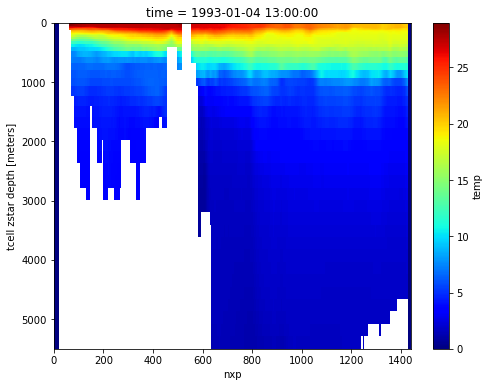

In [11]:

temp_south.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

Now let's remove the missing values to make sure we don't have problems with the inconsistency between the coarse global and high resolution regional bathymetries. We can easily perform this operation using xarray ffill (forward fill) or bfill (backward fill), that come from bottleneck. Forward or backward are relative to the array indexing. In this case, we're going to fill forward along locations then forward in depth (surface is index 0):

In [12]:
drowned_temp_south = temp_south.bfill(dim='nxp').ffill(dim='st_ocean')

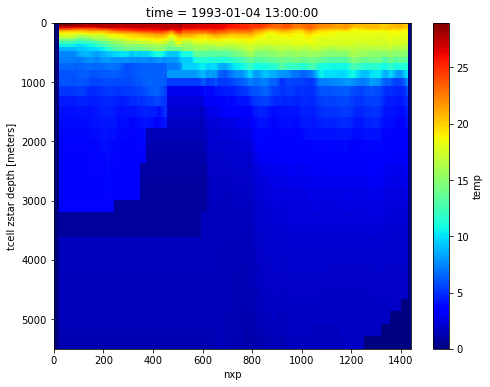

In [13]:
drowned_temp_south.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

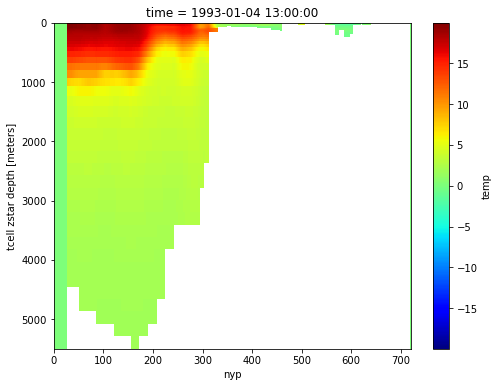

In [14]:
temp_east = regrid_east(ds_cut['temp'])
temp_east.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

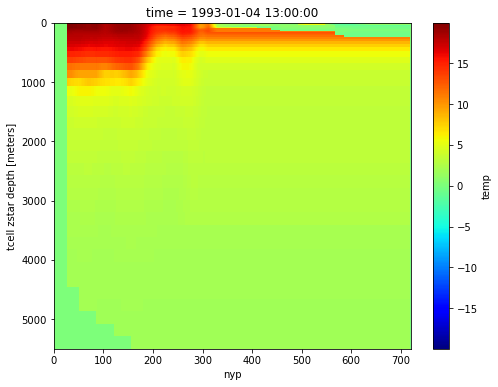

In [15]:
drowned_temp_east = temp_east.ffill(dim='nyp').ffill(dim='st_ocean')
drowned_temp_east.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

## 5. Initial Conditions

Now let's look at how we can create initial conditions for temperature. First we need a xESMF regridder for the whole domain:

In [16]:
regrid_domain = xesmf.Regridder(ds_cut.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'}), ds_nwa.rename({'x': 'lon', 'y': 'lat'}), 'bilinear', 
                                periodic=False, filename='regrid_domain.nc')

Before remapping we're going to extrapolate ocean values onto land, again to deal with inconsistencies between global and regional bathymetry data. But instead of using xarray ffill/bfill, which only work along one axis at the time, we're gonna use a bidimensional extrapolation algo from Kara et al. The extrapolation has been re-coded in python, optimized with numba and wrapped for xarray/dask lazy operation in HCtFlood:

In [17]:
# code courtesy of Raphael Dussin - https://github.com/raphaeldussin/HCtFlood/blob/master/HCtFlood/kara.py

from numba import njit
import numpy as np
from dask.base import tokenize
import dask.array as dsa
import xarray as xr


def flood_kara(data, xdim='lon', ydim='lat', zdim='z', tdim='time',
               spval=1e+15):
    """Apply extrapolation onto land from Kara algo.
    Arguments:
        data {xarray.DataArray} -- input data
    Keyword Arguments:
        xdim {str} -- name of x dimension (default: {'lon'})
        ydim {str} -- name of y dimension (default: {'lat'})
        zdim {str} -- name of z dimension (default: {'z'})
        tdim {str} -- name of time dimension (default: {'time'})
        spval {float} -- missing value (default: {1e+15})
    Returns:
        xarray.DataArray -- result of the extrapolation
    """
    # check for input data shape
    if tdim not in data.dims:
        data = data.expand_dims(dim=tdim)
    if zdim not in data.dims:
        data = data.expand_dims(dim=zdim)

    nrec = len(data[tdim])
    nlev = len(data[zdim])
    ny = len(data[ydim])
    nx = len(data[xdim])
    shape = (nrec, nlev, ny, nx)
    chunks = (1, 1, ny, nx)

    def compute_chunk(zlev, trec):
        data_slice = data.isel({tdim: trec, zdim: zlev})
        return flood_kara_xr(data_slice, spval=spval)[None, None]

    name = str(data.name) + '-' + tokenize(data.name, shape)
    dsk = {(name, rec, lev, 0, 0,): (compute_chunk, lev, rec)
           for lev in range(nlev)
           for rec in range(nrec)}

    out = dsa.Array(dsk, name, chunks,
                    dtype=data.dtype, shape=shape)

    xout = xr.DataArray(data=out, name=str(data.name),
                        coords={tdim: data[tdim],
                                zdim: data[zdim],
                                ydim: data[ydim],
                                xdim: data[xdim]},
                        dims=(tdim, zdim, ydim, xdim))

    # rechunk the result
    xout = xout.chunk({tdim: 1, zdim: nlev, ydim: ny, xdim: nx})

    return xout

def flood_kara_xr(dataarray, spval=1e+15):
    """Apply flood_kara on a xarray.dataarray
    Arguments:
        dataarray {xarray.DataArray} -- input 2d data array
    Keyword Arguments:
        spval {float} -- missing value (default: {1e+15})
    Returns:
        numpy.ndarray -- field after extrapolation
    """

    masked_array = dataarray.squeeze().to_masked_array()
    out = flood_kara_ma(masked_array, spval=spval)
    return out

def flood_kara_ma(masked_array, spval=1e+15):
    """Apply flood_kara on a numpy masked array
    Arguments:
        masked_array {np.ma.masked_array} -- array to extrapolate
    Keyword Arguments:
        spval {float} -- missing value (default: {1e+15})
    Returns:
        out -- field after extrapolation
    """

    field = masked_array.data

    if np.isnan(field).all():
        # all the values are NaN, can't do anything
        out = field.copy()
    else:
        # proceed with extrapolation
        field[np.isnan(field)] = spval
        mask = np.ones(field.shape)
        mask[masked_array.mask] = 0
        out = flood_kara_raw(field, mask)
    return out


def flood_kara_raw(field, mask, nmax=1000):
    """Extrapolate land values onto land using the kara method
    (https://doi.org/10.1175/JPO2984.1)
    Arguments:
        field {np.ndarray} -- field to extrapolate
        mask {np.ndarray} -- land/sea binary mask (0/1)
    Keyword Arguments:
        nmax {int} -- max number of iteration (default: {1000})
    Returns:
        drowned -- field after extrapolation
    """

    ny, nx = field.shape
    nxy = nx * ny
    # create fields with halos
    ztmp = np.zeros((ny+2, nx+2))
    zmask = np.zeros((ny+2, nx+2))
    # init the values
    ztmp[1:-1, 1:-1] = field.copy()
    zmask[1:-1, 1:-1] = mask.copy()

    ztmp_new = ztmp.copy()
    zmask_new = zmask.copy()
    #
    nt = 0
    while (zmask[1:-1, 1:-1].sum() < nxy) and (nt < nmax):
        for jj in np.arange(1, ny+1):
            for ji in np.arange(1, nx+1):

                # compute once those indexes
                jjm1 = jj-1
                jjp1 = jj+1
                jim1 = ji-1
                jip1 = ji+1

                if (zmask[jj, ji] == 0):
                    c6 = 1 * zmask[jjm1, jim1]
                    c7 = 2 * zmask[jjm1, ji]
                    c8 = 1 * zmask[jjm1, jip1]

                    c4 = 2 * zmask[jj, jim1]
                    c5 = 2 * zmask[jj, jip1]

                    c1 = 1 * zmask[jjp1, jim1]
                    c2 = 2 * zmask[jjp1, ji]
                    c3 = 1 * zmask[jjp1, jip1]

                    ctot = c1 + c2 + c3 + c4 + c5 + c6 + c7 + c8

                    if (ctot >= 3):
                        # compute the new value for this point
                        zval = (c6 * ztmp[jjm1, jim1] +
                                c7 * ztmp[jjm1, ji] +
                                c8 * ztmp[jjm1, jip1] +
                                c4 * ztmp[jj, jim1] +
                                c5 * ztmp[jj, jip1] +
                                c1 * ztmp[jjp1, jim1] +
                                c2 * ztmp[jjp1, ji] +
                                c3 * ztmp[jjp1, jip1]) / ctot

                        # update value in field array
                        ztmp_new[jj, ji] = zval
                        # set the mask to sea
                        zmask_new[jj, ji] = 1
        nt += 1
        ztmp = ztmp_new.copy()
        zmask = zmask_new.copy()

        if nt == nmax:
            raise ValueError('number of iterations exceeded maximum, '
                             'try increasing nmax')

    drowned = ztmp[1:-1, 1:-1]

    return drowned

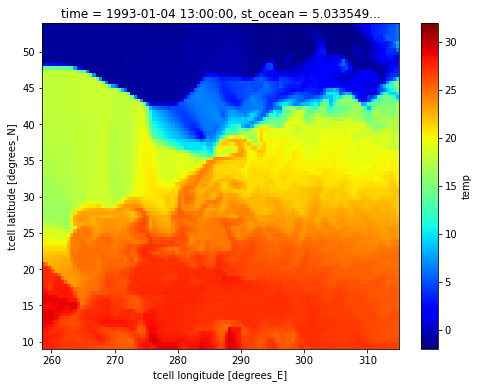

In [18]:
drowned_temp = flood_kara(ds_cut['temp'], xdim='xt_ocean', ydim='yt_ocean', zdim='st_ocean')
drowned_temp.isel(time=0, st_ocean=0).plot(figsize=[8, 6], vmin=-2, vmax=32, cmap='jet')